# Summer School on Data Science Tools and Techniques in Modelling Complex Networks

### [Bogumił Kamiński](http://bogumilkaminski.pl/about/)

## Working with graph data using Julia Language
### Day 2, Tuesday, August 20th, 2019, 13:00 to 16:00

## Spatial Preferrential Attachment

Recent reference for the model: https://arxiv.org/pdf/1802.05127.pdf

SPA graph is directed. We add vertices sequentially using the following procedure:

1. place a new vertex $v$ randomly on a $[0,1)^2$ plane at time $t$
2. Look at all vertices already in the graph
3. Each existing vertex $w$ has a ball of influence of volume $(A_1deg_{in}(w)+A_2)/t$, where $deg_{in}(w)$ is in-degree of $w$ and we perform calculations on a torus
4. If $v$ is in the ball of influence of $w$ then we add an edge from $v$ to $w$ with probability $p$

An average out degree (and in-degree) is asymptotically $pA_2/(1-pA_1)$

In [1]:
using Pkg
Pkg.activate(".")

using LightGraphs, GraphPlot, Roots, Random, PyPlot

structure holding SPA Graph data

In [2]:
mutable struct SPAGraph{T<:DiGraph}
    g::T
    p::Float64
    A₁::Float64
    A₂::Float64
    l::Vector{Tuple{Float64,Float64}}
end

squared distance between $(x_1, y_1)$ and $(x_2, y_2)$ on $[0,1]^2$ torus

In [3]:
function d²torus(d)
    if d > 0.5
        d = 1.0 - d
    elseif d < -0.5
        d = 1.0 + d
    end
    return d^2
end

euclidean(x₁, y₁, x₂, y₂) = sqrt(d²torus(x₁-x₂) + d²torus(y₁-y₂))

euclidean (generic function with 1 method)

calculates ball radius on $[0,1]^2$ torus

In [4]:
function vol2r(vol)
    if vol ≤ π/4
        return sqrt(vol/π)
    end
    if vol ≥ 1.0
        return sqrt(0.5)
    end
    x = find_zero((0.5, sqrt(0.5))) do r
        π*r^2 - 4 * (r^2*acos(0.5/r) - 0.5*sqrt(r^2-0.25)) - vol
    end
    return x
end

vol2r (generic function with 1 method)

randomly decide if an edge from $j$ to $i$ should be added

In [5]:
function sample_edge(sg::SPAGraph, i, j)
    vol = (sg.A₁*indegree(sg.g, j)+sg.A₂)/(i-1)
    r = vol2r(vol)
    if euclidean(sg.l[i][1], sg.l[i][2], sg.l[j][1], sg.l[j][2]) ≤ r && rand() ≤ sg.p
        add_edge!(sg.g, i, j)
        return true
    end
    return false
end

sample_edge (generic function with 1 method)

a naive SPA graph generator with $O(N^2)$ complexity

In [6]:
function gen_spa(N, p, A₁, A₂)
    g = DiGraph(N)
    l = [(rand(), rand()) for i in 1:N]
    sg = SPAGraph(g, p, A₁, A₂, l)
    for i in 2:N, j in 1:(i-1)
        sample_edge(sg, i, j)
    end
    sg
end

gen_spa (generic function with 1 method)

A more efficient method for growing SPA Graph uses a similar idea we already used in random geometric graph.

The difference follows the fact that different vertices have a different radius.

1. We first divide the vertices into light (low in-degree) and heavy (high in-degree)
2. We always check the heavy vertices (as they might have a very big radius)
3. We split the $[0,1)^2$ square into $k^2$ sub squares similarly we did in Random Geometric Graph, as we are sure light vertices do not have a large sphere of influence
4. We have to control for the fact that if some light vertex is lucky is might become heavy in the process

As we have 8 small squares adjacent to the given small square, we select the square size so that approximately the number of heavy vertices is of order of the number of light vertices we visit in the neighborhood of the new vertex.

In [7]:
function split_g(g, l, A₁, A₂, p)
    n = nv(g)
    # constant for a balance between heavy and light vertices count
    T = n^(1-1/(p*A₁+1)) * (9*p*A₁*A₂/π)^(1/(p*A₁+1))
    # number of small squares
    k² = π*n / (A₂ * (1 + (n/T)^(p*A₁)))
    # cut-off degree for a vertex being heavy
    d = floor(Int, (π*n / k² - A₂) / A₁)
    k = floor(Int,sqrt(k²))

    heavy = Set{Int}()
    light = [Set{Int}() for i in 1:k, j in 1:k]

    for i in vertices(g)
        if indegree(g, i) ≥ d
            push!(heavy, i)
        else
            x, y = l[i]
            push!(light[1 + floor(Int, x * k), 1 + floor(Int, y * k)], i)
        end
    end
    k, d, heavy, light
end

split_g (generic function with 1 method)

In [8]:
function grow_spa!(ΔN, sg::SPAGraph)
    k, d, heavy, light = split_g(sg.g, sg.l, sg.A₁, sg.A₂, sg.p)
    N = nv(sg.g)
    add_vertices!(sg.g, ΔN)
    append!(sg.l, [(rand(), rand()) for i in 1:ΔN])
    for i in (N+1):(N+ΔN)
        for j in heavy
            sample_edge(sg, i, j)
        end
        x, y = sg.l[i]
        cx = 1 + floor(Int, x * k)
        cy = 1 + floor(Int, y * k)
        for dx in -1:1, dy in -1:1
            ccx = mod1(cx + dx, k)
            ccy = mod1(cy + dy, k)
            to_heavy = Int[]
            for j in light[ccx, ccy]
                if sample_edge(sg, i, j) && indegree(sg.g, j) ≥ d
                    push!(to_heavy, j)
                end
            end
            for j in to_heavy
                pop!(light[ccx, ccy], j)
                push!(heavy, j)
            end
        end
        push!(light[cx, cy], i)
    end
    sg
end

grow_spa! (generic function with 1 method)

In [9]:
p = 0.1
A₁ = 1.0
d = 10.0

10.0

In [10]:
g1 = gen_spa(20, p, A₁, d*(1/p-A₁))

SPAGraph{SimpleDiGraph{Int64}}({20, 14} directed simple Int64 graph, 0.1, 1.0, 90.0, Tuple{Float64,Float64}[(0.985733, 0.538147), (0.562252, 0.669234), (0.495288, 0.693153), (0.120376, 0.225753), (0.872706, 0.341262), (0.820045, 0.335165), (0.432663, 0.880067), (0.0392645, 0.35866), (0.0695896, 0.678183), (0.0383248, 0.981826), (0.599497, 0.879025), (0.0940111, 0.614542), (0.782343, 0.588174), (0.126866, 0.0220046), (0.883944, 0.864997), (0.301771, 0.264362), (0.371226, 0.705047), (0.230413, 0.938654), (0.733202, 0.988271), (0.127649, 0.658609)])

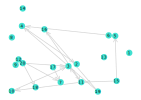

In [11]:
gplot(g1.g, getindex.(g1.l, 1), getindex.(g1.l, 2), nodelabel=1:nv(g1.g))

### Mean degree

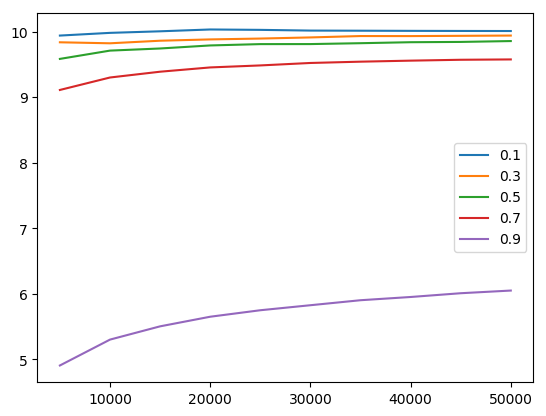

PyObject <matplotlib.legend.Legend object at 0x00000000011F5240>

In [12]:
res = Vector{Float64}[]
for (i, p) in enumerate(0.1:0.2:0.9)
    g = gen_spa(5000, p, A₁, d*(1/p-A₁))
    push!(res, [ne(g.g)/nv(g.g)])
    for j in 1:9
        grow_spa!(5000, g)
        push!(res[i], ne(g.g)/nv(g.g))
    end
end
foreach(x -> plot(5000:5000:50000, x), res)
legend(0.1:0.2:0.9)

### Giant component

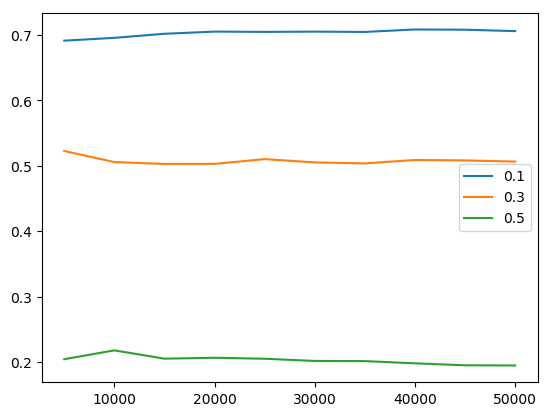

PyObject <matplotlib.legend.Legend object at 0x000000000125BA20>

In [13]:
res = Vector{Float64}[]
d = 1
for (i, p) in enumerate(0.1:0.2:0.5)
    g = gen_spa(5000, p, A₁, d*(1/p-A₁))
    push!(res, [maximum(length.(weakly_connected_components(g.g))) / nv(g.g)])
    for j in 1:9
        grow_spa!(5000, g)
        push!(res[i], maximum(length.(weakly_connected_components(g.g))) / nv(g.g))
    end
end
foreach(x -> plot(5000:5000:50000, x), res)
legend(0.1:0.2:0.5)